## Imports

In [272]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow.keras import datasets, layers, models

from os import listdir
from os.path import isfile, join

## Some initial config

In [273]:
INPUT_DIMS = [64,64]
BIN_DTYPE = 'int16'
PATH = "../Images/bin/"
SAMPLE = None
TEST_SIZE = 0.2
VALIDATION_SIZE = 0.15/(1-TEST_SIZE)

## Generate label DataFrame

In [274]:
liver_images = np.array([f for f in listdir(PATH) if isfile(join(PATH, f))])
#print(f"Number of liver image files: {len(liver_images)}")
cancer_types = np.array([f.split('_')[0] for f in liver_images])
patient_numbers = np.array([int(f.split('_')[1]) for f in liver_images])
slice_numbers = np.array([int(f.split('_')[2].split('.')[0]) for f in liver_images])

ldata = {'filename' : liver_images, 
         'cancer_type' : cancer_types, 
         'patient_id' : patient_numbers, 
         'slice_number' : slice_numbers}

image_labels = pd.DataFrame(data=ldata).sort_values(['cancer_type','patient_id','slice_number'],
                                                   ignore_index=True)
if SAMPLE:
    image_labels = image_labels.sample(SAMPLE)
image_labels.head()

,filename,cancer_type,patient_id,slice_number
0,HCC_1_1.bin,HCC,1,1
1,HCC_1_2.bin,HCC,1,2
2,HCC_1_3.bin,HCC,1,3
3,HCC_1_4.bin,HCC,1,4
4,HCC_1_5.bin,HCC,1,5


### Display some sample images

In [275]:
def get_image(fpath,d_type=BIN_DTYPE,dims=INPUT_DIMS):
    '''
    Returns a numpy array given a .bin file path and
    image dimensionality. Assumes input bin files are square
    
    Parameters
        fpath: file path to .bin file
        d_type: data type of .bin file
        dims: image dimensionality
    Returns
        image: numpy array from bin file data
    '''
    im_data = np.fromfile(fpath,d_type)
    n = int(np.sqrt(len(im_data)))
    image = np.reshape(np.fromfile(fpath,d_type),[n,n])
    scaled_image = cv2.resize(image,dims)
    return scaled_image

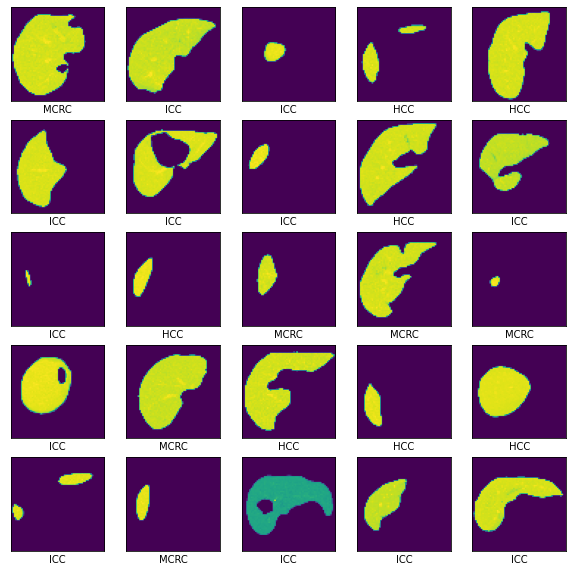

In [276]:
sample_labels = image_labels.sample(25)


plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    
    img = get_image(PATH+sample_labels.filename.iloc[i])
    ctype = sample_labels.cancer_type.iloc[i]
    plt.imshow(img)
    plt.xlabel(ctype)
plt.show()

## Split Data into training and testing sets

In [277]:
#split df into cancer types
HCC_labels = image_labels.loc[image_labels.cancer_type == 'HCC']
ICC_labels = image_labels.loc[image_labels.cancer_type == 'ICC']
MCRC_labels = image_labels.loc[image_labels.cancer_type == 'MCRC']
print(f"{len(HCC_labels)} HCC images found")
print(f"{len(ICC_labels)} ICC images found")
print(f"{len(MCRC_labels)} MCRC images found")

5974 HCC images found
13140 ICC images found
9482 MCRC images found


In [278]:
from sklearn.model_selection import train_test_split

def split_patients(pat_ids,tsize=TEST_SIZE):
    train, test = train_test_split(pat_ids, test_size=tsize)
    return train, test

In [279]:
#for each cancer type, split into training, validation, and testing sets
hcc_all_train_ids, hcc_test_ids = split_patients(HCC_labels.patient_id.unique())
hcc_train_ids, hcc_valid_ids = split_patients(hcc_all_train_ids, VALIDATION_SIZE)

icc_all_train_ids, icc_test_ids = split_patients(ICC_labels.patient_id.unique())
icc_train_ids, icc_valid_ids = split_patients(icc_all_train_ids, VALIDATION_SIZE)

mcrc_all_train_ids, mcrc_test_ids = split_patients(MCRC_labels.patient_id.unique())
mcrc_train_ids, mcrc_valid_ids = split_patients(mcrc_all_train_ids, VALIDATION_SIZE)

#then generate label dataframes for each
HCC_train_labels = HCC_labels.loc[HCC_labels.patient_id.isin(hcc_train_ids)]
HCC_valid_labels = HCC_labels.loc[HCC_labels.patient_id.isin(hcc_valid_ids)]
HCC_test_labels = HCC_labels.loc[HCC_labels.patient_id.isin(hcc_test_ids)]

ICC_train_labels = ICC_labels.loc[ICC_labels.patient_id.isin(icc_train_ids)]
ICC_valid_labels = ICC_labels.loc[ICC_labels.patient_id.isin(icc_valid_ids)]
ICC_test_labels = ICC_labels.loc[ICC_labels.patient_id.isin(icc_test_ids)]

MCRC_train_labels = MCRC_labels.loc[MCRC_labels.patient_id.isin(mcrc_train_ids)]
MCRC_valid_labels = MCRC_labels.loc[MCRC_labels.patient_id.isin(mcrc_valid_ids)]
MCRC_test_labels = MCRC_labels.loc[MCRC_labels.patient_id.isin(mcrc_test_ids)]

In [280]:
train_rows=pd.concat([MCRC_train_labels,ICC_train_labels,HCC_train_labels],ignore_index=True).sample(frac=1)
valid_rows=pd.concat([MCRC_valid_labels,ICC_valid_labels,HCC_valid_labels],ignore_index=True).sample(frac=1)
test_rows=pd.concat([MCRC_test_labels,ICC_test_labels,HCC_test_labels],ignore_index=True).sample(frac=1)

total = len(train_rows) + len(valid_rows) + len(test_rows)
print(f"{total} total images split")
print(f"Train/validation/test ratio: {len(train_rows)/total:.2f}/{len(valid_rows)/total:.2f}/{len(test_rows)/total:.2f}")

28596 total images split
Train/validation/test ratio: 0.64/0.15/0.20


In [281]:
# dict to map cancer types to numerical classes
c_class = {'HCC':0,
          'ICC':1,
          'MCRC':2}

In [282]:
#preallocate training data array
n_train = len(train_rows)
train_images = np.zeros([n_train]+INPUT_DIMS,dtype=BIN_DTYPE)

for i in range(n_train):
    print(f"{i+1}/{n_train}", end='\r')
    train_images[i,:,:]=get_image(PATH+train_rows.filename.iloc[i])

train_labels = np.array([[c_class[c]] for c in train_rows.cancer_type.tolist()])

In [283]:
#preallocate validation data array
n_valid = len(valid_rows)
valid_images = np.zeros([n_valid]+INPUT_DIMS,dtype=BIN_DTYPE)

for i in range(n_valid):
    print(f"{i+1}/{n_valid}", end='\r')
    valid_images[i,:,:]=get_image(PATH+valid_rows.filename.iloc[i])

valid_labels = np.array([[c_class[c]] for c in valid_rows.cancer_type.tolist()])

In [284]:
#preallocate testing data array
n_test = len(test_rows)
test_images = np.zeros([n_test]+INPUT_DIMS,dtype=BIN_DTYPE)

for i in range(n_test):
    print(f"{i+1}/{n_test}", end='\r')
    test_images[i,:,:]=get_image(PATH+test_rows.filename.iloc[i])

test_labels = np.array([[c_class[c]] for c in test_rows.cancer_type.tolist()])

## Create Convolutional Base

In [306]:
model = models.Sequential()

model.add(layers.Conv2D(filters=16, kernel_size=(8, 8), activation='relu', input_shape=(INPUT_DIMS[0],INPUT_DIMS[0],1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(filters=32, kernel_size=(8, 8), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(3))
          
model.summary()

Model: "sequential_47"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_102 (Conv2D)         (None, 57, 57, 16)        1040      
                                                                 
 max_pooling2d_73 (MaxPoolin  (None, 28, 28, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_103 (Conv2D)         (None, 21, 21, 32)        32800     
                                                                 
 max_pooling2d_74 (MaxPoolin  (None, 10, 10, 32)       0         
 g2D)                                                            
                                                                 
 flatten_39 (Flatten)        (None, 3200)              0         
                                                                 
 dense_105 (Dense)           (None, 128)             

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, batch_size=32,
                    validation_data=(valid_images, valid_labels),verbose=True)

Epoch 1/10
575/575 [==============================] - 42s 73ms/step - loss: 8.2851 - accuracy: 0.4611 - val_loss: 1.0895 - val_accuracy: 0.4083
Epoch 2/10
575/575 [==============================] - 45s 78ms/step - loss: 1.0432 - accuracy: 0.4674 - val_loss: 1.0892 - val_accuracy: 0.4083
Epoch 3/10
575/575 [==============================] - 53s 93ms/step - loss: 1.0435 - accuracy: 0.4674 - val_loss: 1.0905 - val_accuracy: 0.4083
Epoch 4/10
575/575 [==============================] - 71s 123ms/step - loss: 1.0433 - accuracy: 0.4674 - val_loss: 1.0891 - val_accuracy: 0.4083
Epoch 5/10
575/575 [==============================] - 65s 113ms/step - loss: 1.0434 - accuracy: 0.4674 - val_loss: 1.0870 - val_accuracy: 0.4083
Epoch 6/10
575/575 [==============================] - 53s 92ms/step - loss: 1.0434 - accuracy: 0.4674 - val_loss: 1.0949 - val_accuracy: 0.4083
Epoch 7/10
504/575 [=========================>....] - ETA: 6s - loss: 1.0412 - accuracy: 0.4714

In [ ]:
plt.figure(1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.figure(2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 2])
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)
print(test_acc)